# Ransac sift homography
0.	选择两幅部分内容一致，部分内容不同的图像，两者可以有角度/位移等变化。
1.	对两幅图像分别进行关键点检测，比如用 SIFT.
2.	对两幅图像的关键点进行进行匹配并用 RANSAC 去噪，找到单应性关系
3.	将第二幅图像按照单应性关系进行变换 
4.	将两幅图像相互对应的点重合，其余点也即进行融合。因旋转造成图像 size 大小不同等， 补 0 即可。

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
print(cv2.__version__)

3.4.2


In [3]:
img1 = cv2.imread('IMG_1336.jpg')
img2 = cv2.imread('IMG_1337.jpg')
img3 = cv2.imread('IMG_1338.jpg')
images = [img1,img2,img3]

In [4]:
def my_show(img):
    plt.figure(figsize=(10,10),dpi=100)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

## OpenCV自带的Stitch方法

In [6]:
stitcher = cv2.createStitcher()

In [7]:
(status, stitched) = stitcher.stitch(images)

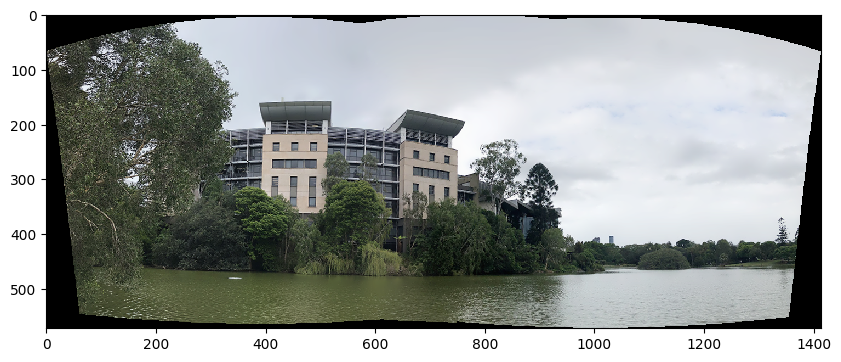

In [8]:
my_show(stitched)

## 手动实现

### 用SIFT对两幅图像分别进行关键点检测

In [10]:
sift = cv2.xfeatures2d.SIFT_create()

In [15]:
kp1, des1 = sift.detectAndCompute(img1, None)
des1.shape

(3104, 128)

In [16]:
def show_key_points(img, kp):
    img_sift = cv2.drawKeypoints(img, kp, outImage=np.array([]),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(10,10),dpi=100)
    my_show(img_sift)

<Figure size 1000x1000 with 0 Axes>

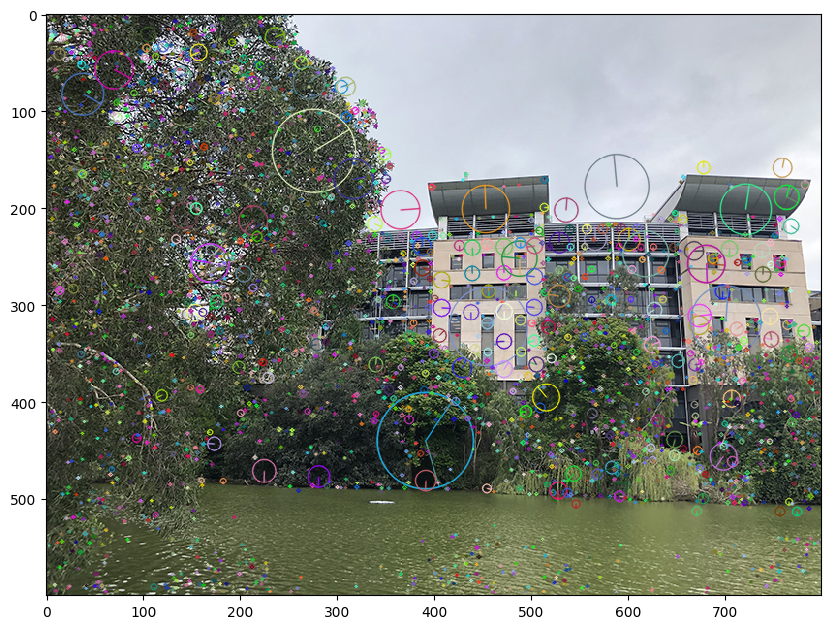

In [17]:
show_key_points(img1, kp1)

<Figure size 1000x1000 with 0 Axes>

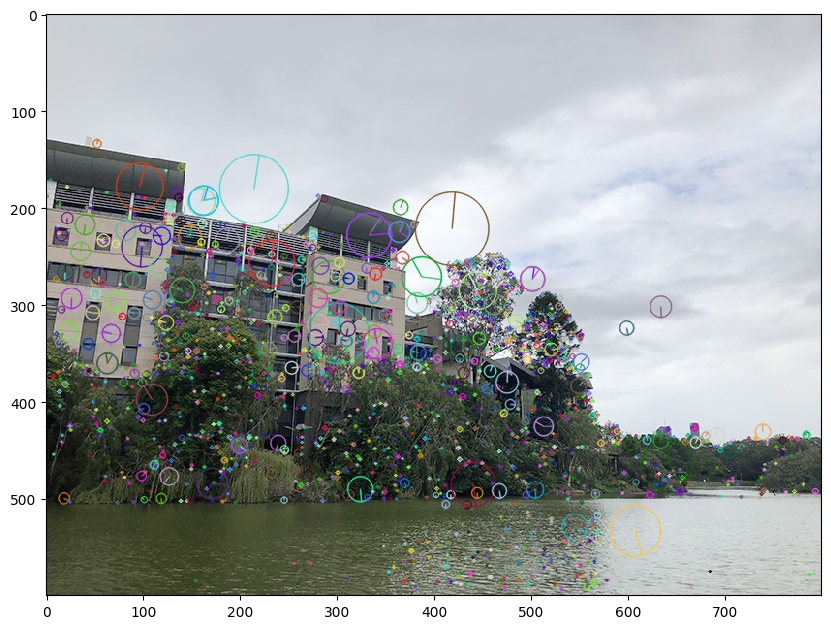

In [18]:
kp2, des2 = sift.detectAndCompute(img2, None)
show_key_points(img2,kp2)

### 用knnMatch对关键点进行匹配，RANSAC去噪

In [21]:
# matcher = cv2.BFMatcher()
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
raw_matches = matcher.knnMatch(des1, des2, k=2)

In [22]:
ratio=0.85
min_match=10
smoothing_window_size=800

In [23]:
good_points = []
good_matches=[]

for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])

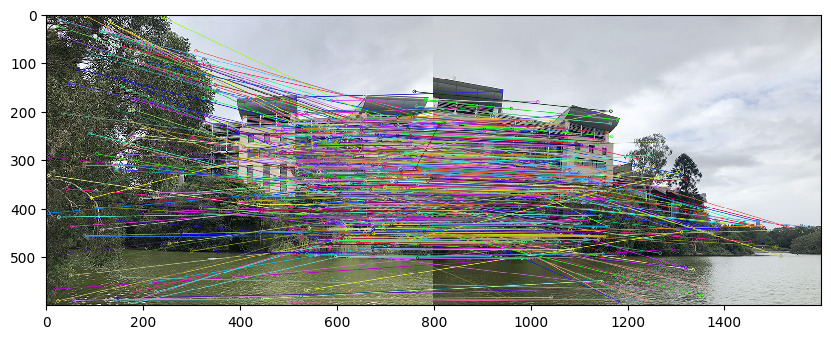

In [24]:
img_match_knn = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)

my_show(img_match_knn)

获取单应性矩阵H

In [25]:
if len(good_points) > min_match:
    image1_kp = np.float32(
        [kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32(
        [kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)

### 将第二幅图像按照单应性关系进行变换

全景图画布高为第一张图，宽为两张图之和。

In [19]:
height_panorama = img1.shape[0]
width_panorama = img1.shape[1] + img2.shape[1]

In [ ]:
第2张图变换使用全景图画布尺寸。

In [26]:
panorama = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))

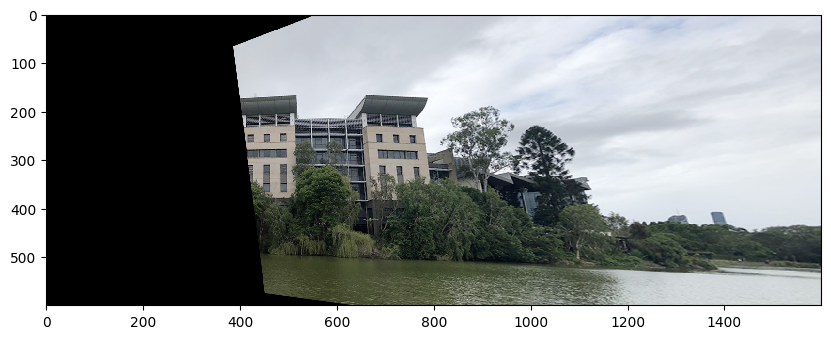

In [28]:
my_show(panorama)

### 将第2张图与第1张图合并

In [29]:
panorama[0:img1.shape[0], 0:img1.shape[1], :] = img1

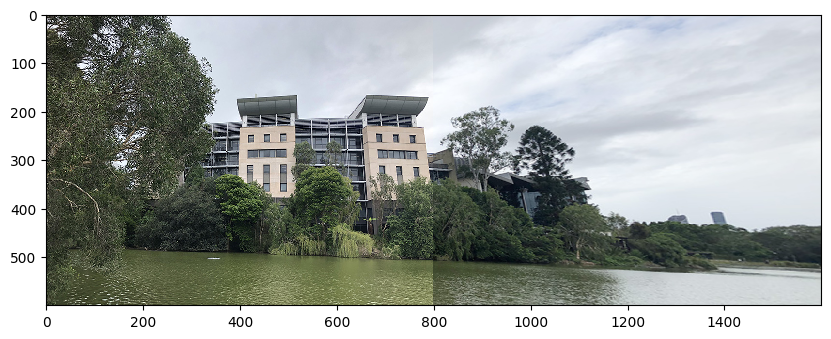

In [30]:
my_show(panorama2)